<a href="https://colab.research.google.com/github/MilenaArakelyan17/AI_Image_Generator/blob/main/Another_copy_of_Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection



Let's load in some useful libraries by running the cell below

In [ ]:
!pip install scikeras > /dev/null
!pip install keras==2.12.0 > /dev/null

import os
import numpy as np
import pandas as pd
import random
import cv2

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score


from sklearn.metrics import f1_score, confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay

from keras.models import Model
from keras.models import Sequential
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.layers import Dense
from keras.layers import Flatten


from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from imgaug import augmenters


import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
import tensorflow.keras as keras
#import scikeras
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.regularizers import l2
#from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires keras>=3.2.0, but you have keras 2.12.0 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }

from imgaug import augmenters
def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)

def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = scale)
  return augment(data, fun)

def flip_left_right(data, prob):
  fun = augmenters.Fliplr(p = prob)
  return augment(data, fun)

def flip_up_down(data, prob):
  fun = augmenters.Flipud(p = prob)
  return augment(data, fun)

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    field_data, field_labels = get_data_split('field', flatten, all_data, metadata, image_shape)
    field_data[:,:,:,2] = field_data[:,:,:,0]
    field_data[:,:,:,1] = field_data[:,:,:,0]

    #make data messier
    for i in range(len(field_data)):
      image = field_data[i]
      rand = random.uniform(-1, 1)
      if abs(rand) < 0.7:
        image = rotate(image, rotate = rand * 20)
      rand = random.uniform(-1, 1)
      if abs(rand) < 0.7:
        image = shear(image, shear = rand*40)
      field_data[i] = image
    return field_data, field_labels

class helpers:
  #### PLOTTING
  def plot_images(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    if num_labels != 0:
      print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 1)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

### defining project variables
# file variables
metadata_url         = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
image_data_url       = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

###
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy"

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_images = lambda data, labels = [], index = None: helpers.plot_images(data = data, labels = labels, index = index, image_shape = image_shape);

metadata.csv        100%[===================>]  39.56K  --.-KB/s    in 0s      
image_data.npy      100%[===================>] 131.25M   195MB/s    in 0.7s    


Among other things, the code above defines a `plot_one_image`to help us quickly view our images. Here's a little overview of how to use it.

`plot_images` can take in either one image or many images. To use it with one image that is 3D, call:

```
plot_images(image)
```

To use it with many images, call:


```
plot_images(data, labels, index)
```

where:
* `data`: all of our images in one array
* `labels`: the labels corresponding to the images
* `index`: which image we want to see


Now let's load our actual data!

In [ ]:
X_train, y_train = get_train_data(flatten = False)
X_test, y_test = get_test_data(flatten = False)

# Your turn! Let's try to classify each image in this dataset as pneumonia or healthy.

Follow these steps:
1. Before you start making machine learning models, take some time to explore your data (```X_train```,```y_train```,```X_test```, and ```y_test```). Things you might want to check out include, but aren't limited to:
    1. How many samples are in each dataset?
    2. What type of data does each dataset contain? What are the dimensions of that data. Try changing the data loading function in the cell above to have an argument of ```flatten = False```. How does that change the shape of the data?
    3. Try showing some of the lungs that have pneumonia, and some that don't (i.e. look at images that have different labels). What is the general difference between the two? Do some internet research on what lungs that have pneumonia look like. Which label do you think corresponds to lungs with pneumonia? Which label do you think corresponds to lungs without pneumonia?
2. Is this a linear regression or a classification problem? At the beginning of class, we created Linear Regression and Logistic Regression models to deal with these two types of problems. These are some of the simplest models we can create. Try creating one of these models, and using it to solve our problem. What sort of performance do you get? (Remember - the performance metric you use should depend on whether this is a linear regression or a classification problem!
3. It turns out that Linear Regression, Logistic Regression, and Neural Network models are not the only types of machine learning models out there. Another often-used model is the K-Nearest Neighbors algorithm, or the KNN algorithm. Read about how it works [here](https://www.geeksforgeeks.org/k-nearest-neighbours/), and take a look at the sci-kit library implementation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). Then try implementing KNN for our pneumonia detection problem.
4. Try implementing a simple neural net, like the one we developed at the end of Neural_Networks colab. You can copy over the code from that colab, but you will need to modify part of it! Hint: think about what's different about our input data.
5. Try implementing a simple CNN (convolutional neural net), like the one we implemented in CNN colab. Play around with the architecture to make a neural net that works well!
6. Let's try some transfer learning! Build a model based off of a powerful, pre-trained image classification model, such as ```VGG16```, ```VGG19```, ```ResNet50```, or ```DenseNet121```.


## Results:
Your results should include a description of the different models you tried, and a comparison of their accuracies

## Step 1: Data Exploration

Number of training samples: 2000
Number of test samples: 400
Shape of each image: (64, 64, 3)


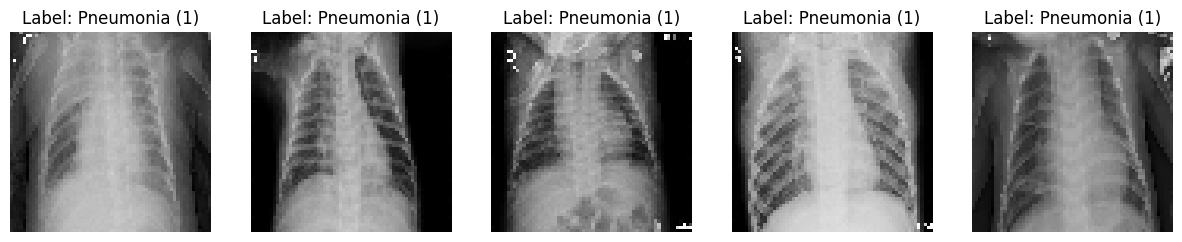

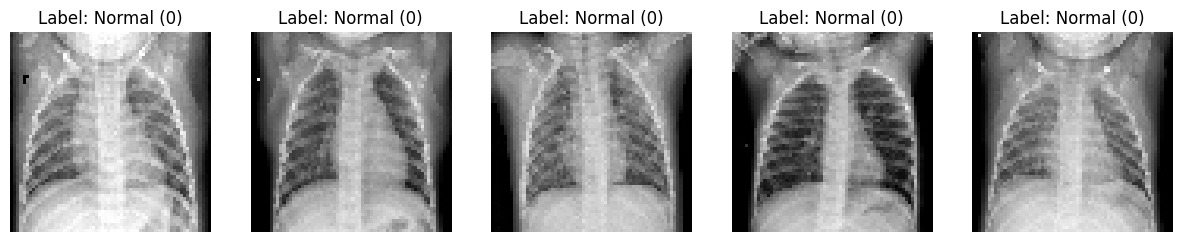

In [ ]:
num_train_samples = len(X_train)
num_test_samples = len(X_test)

print(f"Number of training samples: {num_train_samples}")
print(f"Number of test samples: {num_test_samples}")

image_shape = X_train[0].shape
print(f"Shape of each image: {image_shape}")


def plot_images_with_labels(images, labels, label_name, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(f"Label: {label_name} ({labels[i]})")
        axes[i].axis('off')
    plt.show()

pneumonia_images = [X_train[i] for i in range(len(X_train)) if y_train[i] == 1]
plot_images_with_labels(pneumonia_images, [1]*len(pneumonia_images), "Pneumonia")

normal_images = [X_train[i] for i in range(len(X_train)) if y_train[i] == 0]
plot_images_with_labels(normal_images, [0]*len(normal_images), "Normal")

## Step 2: Logistic Regression

Accuracy: 0.67


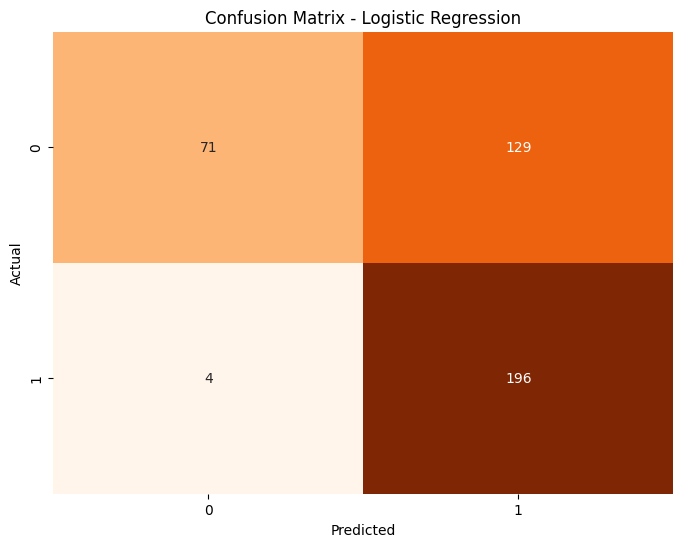

In [ ]:
num_samples_train = X_train.shape[0]
num_samples_test = X_test.shape[0]
X_train_flatten = X_train.reshape(num_samples_train, -1)
X_test_flatten = X_test.reshape(num_samples_test, -1)
model = LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs')

model.fit(X_train_flatten, y_train)
y_pred = model.predict(X_test_flatten)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Oranges', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

## Step 3: K Nearest Neighbors

<ipython-input-2-781e5c752be9>:56: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return get_data_split('train', flatten, all_data, metadata, image_shape)
<ipython-input-2-781e5c752be9>:59: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return get_data_split('test', flatten, all_data, metadata, image_shape)


Accuracy of KNN classifier: 0.77

Confusion Matrix:
[[121  79]
 [ 13 187]]


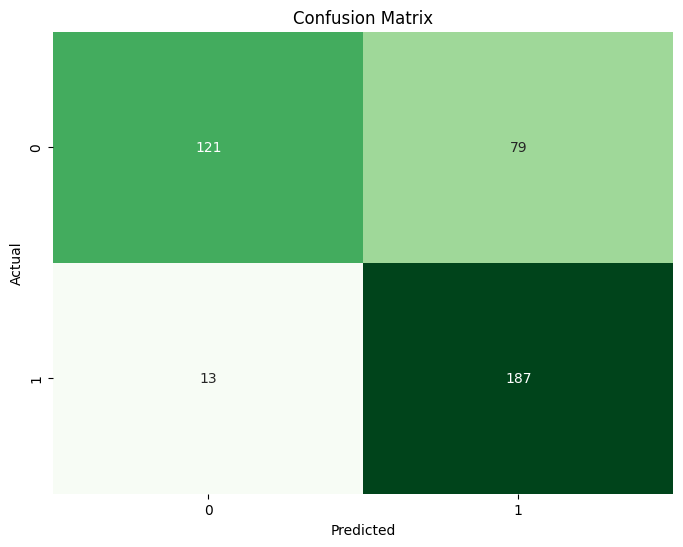

In [ ]:
def get_train_data(flatten, all_data, metadata, image_shape):
    return pkg.get_train_data(flatten=flatten, all_data=all_data, metadata=metadata, image_shape=image_shape)

def get_test_data(flatten, all_data, metadata, image_shape):
    return pkg.get_test_data(flatten=flatten, all_data=all_data, metadata=metadata, image_shape=image_shape)

flatten = True
X_train_flatten, y_train = get_train_data(flatten, _all_data, _metadata, image_shape)
X_test_flatten, y_test = get_test_data(flatten, _all_data, _metadata, image_shape)

k = 4
knn = KNeighborsClassifier(n_neighbors=k)

knn.fit(X_train_flatten, y_train)

y_pred = knn.predict(X_test_flatten)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of KNN classifier: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


 ## Step 4: Simple Neural Network

In [ ]:
image_shape

(64, 64, 3)

Epoch 1/10
63/63 [==============================] - 6s 15ms/step - loss: 0.6523 - accuracy: 0.7280 - val_loss: 0.3922 - val_accuracy: 0.8300
Epoch 2/10
63/63 [==============================] - 0s 7ms/step - loss: 0.2487 - accuracy: 0.9055 - val_loss: 0.3845 - val_accuracy: 0.7975
Epoch 3/10
63/63 [==============================] - 0s 7ms/step - loss: 0.1750 - accuracy: 0.9295 - val_loss: 0.5742 - val_accuracy: 0.7300
Epoch 4/10
63/63 [==============================] - 1s 11ms/step - loss: 0.2162 - accuracy: 0.9120 - val_loss: 0.5093 - val_accuracy: 0.7650
Epoch 5/10
63/63 [==============================] - 1s 11ms/step - loss: 0.1796 - accuracy: 0.9265 - val_loss: 0.4717 - val_accuracy: 0.7625
Epoch 6/10
63/63 [==============================] - 1s 12ms/step - loss: 0.1767 - accuracy: 0.9300 - val_loss: 0.9295 - val_accuracy: 0.6775
Epoch 7/10
63/63 [==============================] - 1s 14ms/step - loss: 0.1455 - accuracy: 0.9425 - val_loss: 0.9701 - val_accuracy: 0.6525
Epoch 8/10
63/6

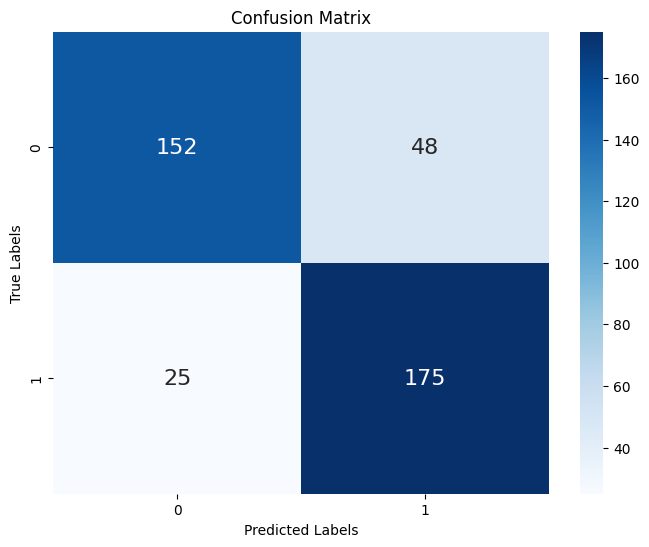

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 128)               1572992   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,581,313
Trainable params: 1,581,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train_flat = np.array(X_train.reshape(X_train.shape[0], -1))
X_test_flat = np.array(X_test.reshape(X_test.shape[0], -1))

model = Sequential([
    Flatten(input_shape=image_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, \
                    validation_data=(X_test, y_test), \
                    epochs=10)

test_loss, test_accuracy = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

f1score = f1_score(y_test, y_pred_binary)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'F1 score: {f1score:.4f}')

cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', annot_kws={'size': 16})

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

model.summary()

## Step 5: Simple CNN (Convolutional Neural Network)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)        

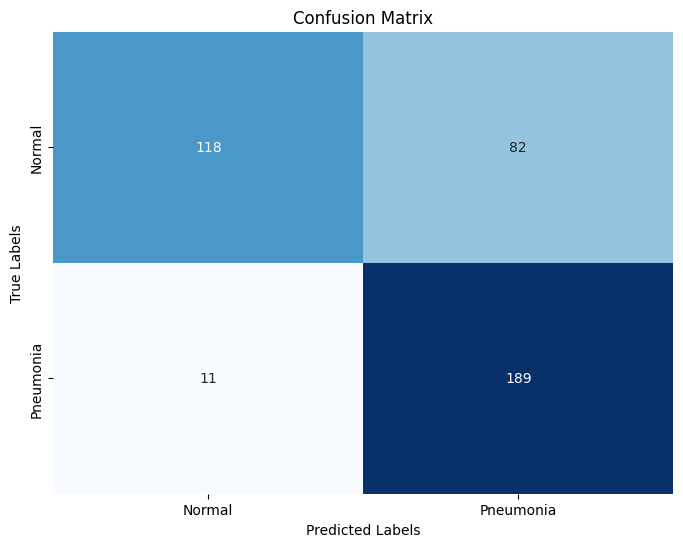

In [ ]:
metadata_path = './metadata.csv'
image_data_path = './image_data.npy'

metadata = pd.read_csv(metadata_path)
image_data = np.load(image_data_path)

def get_train_data(image_data, metadata, image_shape):
    train_metadata = metadata[metadata['split'] == 'train']
    train_indices = train_metadata['index'].values
    X_train = image_data[train_indices]
    y_train = train_metadata['class'].values
    return X_train, y_train

def get_test_data(image_data, metadata, image_shape):
    test_metadata = metadata[metadata['split'] == 'test']
    test_indices = test_metadata['index'].values
    X_test = image_data[test_indices]
    y_test = test_metadata['class'].values
    return X_test, y_test

image_shape = (64, 64, 3)
X_train, y_train = get_train_data(image_data, metadata, image_shape)
X_test, y_test = get_test_data(image_data, metadata, image_shape)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test), verbose=1)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Step 6: Transfer Learning

Define a transfer classifier model of your choosing. (VGG16, VGG19, ResNet50, and DenseNet121 might be good ones to try). Check out some background on these nets [here](https://levelup.gitconnected.com/a-practical-guide-to-selecting-cnn-architectures-for-computer-vision-applications-4a07ef90234)

In [ ]:
metadata_path = './metadata.csv'
image_data_path = './image_data.npy'

metadata = pd.read_csv(metadata_path)
image_data = np.load(image_data_path)

def get_train_data(image_data, metadata):
    train_metadata = metadata[metadata['split'] == 'train']
    train_indices = train_metadata['index'].values
    X_train = image_data[train_indices]
    y_train = train_metadata['class'].values
    return X_train, y_train

def get_test_data(image_data, metadata):
    test_metadata = metadata[metadata['split'] == 'test']
    test_indices = test_metadata['index'].values
    X_test = image_data[test_indices]
    y_test = test_metadata['class'].values
    return X_test, y_test

X_train, y_train = get_train_data(image_data, metadata)
X_test, y_test = get_test_data(image_data, metadata)

input_shape = (64,64,3)

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()





58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 15,239,489
Trainable params: 15,239,489
Non-trainable params: 0
___________________________________________

Epoch 1/5
250/250 [==============================] - 16s 39ms/step - loss: 0.4422 - accuracy: 0.8045 - val_loss: 0.3717 - val_accuracy: 0.8425
Epoch 2/5
250/250 [==============================] - 8s 31ms/step - loss: 0.2751 - accuracy: 0.8875 - val_loss: 0.2633 - val_accuracy: 0.9025
Epoch 3/5
250/250 [==============================] - 8s 31ms/step - loss: 0.2161 - accuracy: 0.9110 - val_loss: 0.2469 - val_accuracy: 0.9025
Epoch 4/5
250/250 [==============================] - 8s 31ms/step - loss: 0.2151 - accuracy: 0.9185 - val_loss: 0.2302 - val_accuracy: 0.9150
Epoch 5/5
13/13 [==============================] - 0s 13ms/step
Test Accuracy: 0.9150


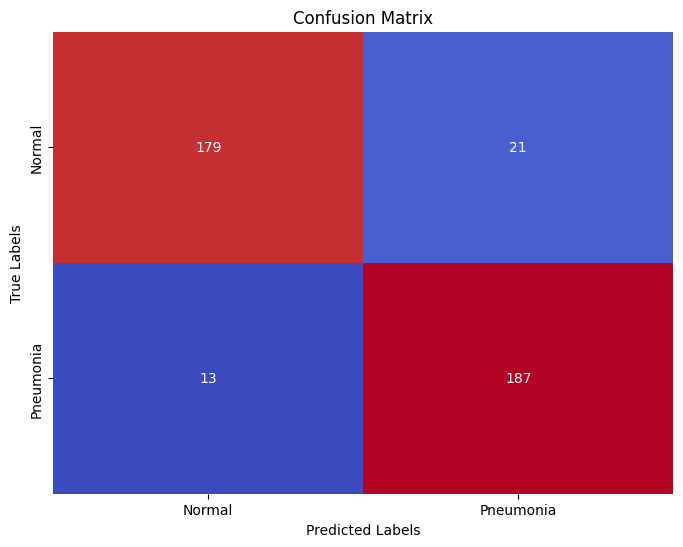

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=8),
                    epochs=5,
                    validation_data=(X_test, y_test),
                    verbose=1)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d', cbar=False,
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Step 7: Comparison of Results

## Step 8:
Is accuracy the best score to evaluate performance on? What about precision and recall? See if you can create a model that optimizes for one of these metrics instead

## Step 9: Testing out our methods on some field data

Load some new field data that you've just received from the newest hospital in your system. Try running some of the classification models you created in the previous steps on these new images. Does performance stay the same?

Try taking a look at some of the images in the field data set. What's different about them? How could we modify our models to adapt to the field image data set?

Hint: search 'data augmentation' online, and see what suggestions you get

Label: 0.0


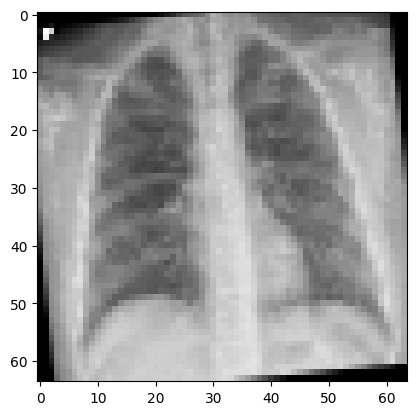

In [ ]:
X_field, y_field = get_field_data(flatten=False)
plot_one_image(X_field, y_field, 56)